# Goal


The goal of this notebook is to show how to implement  and use the RSVP \[[1](https://arxiv.org/abs/1811.01076)\] method in R. 

You can just copy and paste the functions given here and apply the method to your own datasets. 

The following use cases of RSVP are illustrated:
  * 1) how to implement RSVP in order to estimate a covariance matrix in the presence of confounding (latent variables) in a very high-dimensional setting. Its resampled counterpart is also implemented.
  * 2) how to use the estimated covariance matrix to estimate a undirected graph over the observed variables.
  * 3) how to use RSVP in combination with the lasso in order to estimate an undirected graphical model (a.k.a. conditional independence graph) over the observed variables. This amounts to estimating the *inverse* covariance matrix given the covariance matrix computed by RSVP.

You will need the following packages: `MASS` (to generate synthetic data), `ggplot2` (to plot the results), `glasso` (to compute the inverse covariance matrix).


# RSVP : setup and estimator

## Setup

Although some elliptical distributions with fatter tails are supported (see \[[1](https://arxiv.org/abs/1811.01076)\]), we assume here for simplicity that the data is generated from a multivariate Gaussian. Formally, we assume that we are given $n$ samples from a random Gaussian vector $x \in \mathbb{R}^p$ distributed according to:
$$x \sim \mathcal{N}(0, \Sigma + \Gamma \Gamma^T),$$
for $\Gamma \in \mathbb{R}^{p \times q}$ a matrix of *latent factors*. 

Intuitively, our problem is one of unobserved variables: we are interested in $\Sigma$, but the presence of $q$ hidden variables prevents a direct observation of $\Sigma$. The sample covariance is the sum of two matrices, one of which ($\Gamma \Gamma^T$) is a nuisance. This is a problem which has been studied in settings where $n \leq p$, see *e.g.* https://statweb.stanford.edu/~candes/papers/RobustPCA.pdf, https://projecteuclid.org/euclid.aos/1351602527 . The main drawback of the aforementioned methods is that they are computationally demanding.

## RSVP

RSVP is a simple and fast estimator of $\Sigma$. Let $X$ be the $n \times p$ data matrix which contains $n$ observations of the $p$ random variables. It is assumed that $n < p$.

Then $$\hat{\Sigma}_{RSVP} = VV^T,$$ where $X = U \Lambda V^T$ is the singular value decomposition of $X$. Alternatively, if $\hat{\Theta}$ is the sample covariance matrix of the $n$ samples, then we can write $\hat{\Theta} = \frac{1}{n} V \Lambda^2 V^T$. Thus, $\hat{\Sigma}_{RSVP}$ can also be obtained from the eigendecomposition of the sample covariance matrix.

NOTE: Because the eigenvalues are all shrunk to 1, $\hat{\Sigma}_{RSVP}$ is an estimator of $\Sigma$ **up to a multiplicative factor**.

RSVP can easily be improved by resampling the data and constructing:
$$\hat{\Sigma}_{RSVP-sub} = \frac{1}{B} \sum_{1 \leq i \leq B} V^{(i)} V^{(i) T}$$, where $V(i)$ is the matrix of singular vectors of a random sample of $m$ rows of $X$. In words: we take a random sample of size $m \leq n$ without replacement and compute RSVP on that sub-sample. Estimates are then averaged. When $n$ and $p$ are rather large, choosing a small value of $m$ (~100 or so) can speedup the computation.

# 1 ) *RSVP*: An implementation of RSVP for covariance estimation

## R Code:

In [103]:
# Compute RSVP from an n x p data matrix X.
RSVP <- function(X) {
    # Demean X
    X <- scale(X, scale=FALSE)
    # Return V V^T
    tcrossprod(svd(scale(X, scale=FALSE), nu=0, nv = nrow(X)-1)$v)
}

# Compute the resampled version of RSVP
RSVP_sub <- function(X, n_resample = 100, m = floor(0.2 * nrow(X))) {
    n <- nrow(X)
    Sigmahat <- 0
    for (i in 1:n_resample) {
        idx <- sample(1:n, m, replace=FALSE)
        Sigmahat <- Sigmahat + RSVP(X[idx, ])
    }
    
    Sigmahat / n_resample
}

## Generating synthetic data

We generate a high-dimensional dataset by constructing a sparse positive definite matrix $\Sigma^{-1}$ and 
a matrix of latent factors $L$ such that $\Sigma^{-1} \succeq L \succeq 0$. We then set $\Theta = (\Sigma^{-1} - L)^{-1}$.

The following code generates such synthetic data and also implements a couple of useful functions.

In [148]:
library(MASS) # Required to sample from a multivariate Gaussian

# Function to generate data according to the setup described earlier.
get_synthetic_data <- function(p, n, q, seed=0) {
    # p variables, n samples, q latent factors
    set.seed(seed)

    # A sparse inverse covariance matrix
    Sigmai <- matrix(rnorm(p*p), ncol=p) * matrix(rbinom(p*p, 1, 0.01), ncol=p)
    Sigmai <- 0.5 * (Sigmai + t(Sigmai)) # Roughly 2% of entries should be non-zero
    minE <- min(eigen(Sigmai)$values)
    Sigmai <- Sigmai - minE * diag(p) + 1.0 * diag(p) # Make sure it's pos. def.
    
    # A matrix of latent factors
    G <- mvrnorm(n=p, mu=rep(0, q), Sigma=diag(q)/p) # Matrix of latent factors. Rescaled so that ||L||_2 ~ 1
    L <- G %*% t(G)
    minE <- min(eigen(Sigmai - L)$values) # Let's make sure that Sigmai - L is pos. def.
    if (minE < 0) { # Should happen with very low probability
        print("Sigma_inv - L was not pos. def. Trying with another random sample.")
        return(get_synthetic_data(p, n, q, seed + 1))
    }
    Theta <- solve(Sigmai - L)
    Sigma <- solve(Sigmai)
    
    # Because of our scaling for L the confounding is very weak, so we rescale to something more interesting
    GGT <- Theta - Sigma
    Theta <- Sigma +  sqrt(p) * GGT
    
    # Generate the data
    X <- mvrnorm(n = n, mu=rep(0, p), Sigma = Theta)

    list(X=X, Sigma_inverse=Sigmai, L=L, Sigma=Sigma, Theta=Theta)
}

### Helper functions

# Compute the max norm distance between two matrices
# It is rescaled by the max norm of the second matrix
max_norm_dist <- function (A, B) {
    max(abs(A - B)) / max(abs(B))
}

# Use a simple dichotomy to find the scaling factor that minimises the infinity norm
scan_scaling_factor <- function(estimate, ground.truth, lower_k = 0, upper_k = 1e+4, tol=1e-03) {
    diff <- Inf
    
    # Dichotomy to find the scaling factor minimises the distance to the truth
    while(abs(diff) > tol) {
        low_val <- max_norm_dist(lower_k * estimate, ground.truth)
        upper_val <- max_norm_dist(upper_k * estimate, ground.truth)
        diff <- abs(low_val - upper_val)
        
        mid_k <- 0.5 * (lower_k + upper_k)
        mid_val <- max_norm_dist(mid_k * estimate, ground.truth)
        
        if ((upper_val - mid_val) > (low_val - mid_val)) {
            upper_k <- mid_k            
        } else {
            lower_k <- mid_k
        }
    }
    
    mid_val
}

get_PCA_estimation <- function(X, n.factors) {
    svd.result <- svd(X)
    svd.result$d[1:n.factors] <- 0
    
    svd.result$u %*% diag(svd.result$d) %*% t(svd.result$v)
}

## Comparison to other methods in terms of $\infty$ norm.

Let us look at how well $\Sigma$ is estimated by various methods. Here, we compare:
*  RSVP and RSVP_sub, where we resample m times, for various values of $m$. When $m = n$, RSVP-sub is equivalent to RSVP.
*  The sample covariance matrix $\Sigma_{sample}$.
*  PCA(k): We remove the top $k$ singular values from the data. $\Sigma_{PCA}(k)$ is the covariance of the residuals.

Because $\Sigma_{RSVP}$ and $\Sigma_{RSVP-sub}$ are defined up to a scaling factor, we scan the value of that parameter for all methods and keep the one that gives the best result.

In [154]:
results <- matrix(NA, ncol=6, nrow=0)
colnames(results) <- c("p", "n", "q", "method_base", "method_param", "smallest max norm")

# It takes quite a bit of time to generate the data etc...
# You can set n.rep to a lower value.
n.rep <- 20
for (rep in 1:n.rep) {
    p <- 1000
    n <- 200
    q <- 50
    # Generate synthetic data with p variables, n samples and q latent factors
    # This step is rather slow....
    data <- get_synthetic_data(p=p, n=n, q=q, seed = rep)
    X <- data$X
    Sigma <- data$Sigma
    
    method_base <- "RSVP-sub"
    ms <- floor(n * 0.1 * c(1:10))
    for (m in ms) {
        Sigma_RSVP_sub <- RSVP_sub(X, m=m)
        inf_max_norm <- scan_scaling_factor(Sigma_RSVP_sub, Sigma)
        results <- rbind(results, c(p, n, q, method_base, m, inf_max_norm))
    }

    method <- "PCA"
    Sigma_sample <- cov(X) # This is PCA with 0 factors regressed out.
    inf_max_norm <- scan_scaling_factor(Sigma_sample, Sigma)
    results <- rbind(results, c(p, n, q, method, 0, inf_max_norm))

    method_base <- "PCA"
    for (k in 1:(q+10)) {
        if (k %% 5 != 0) {
            next()
        }
        pca <- get_PCA_estimation(X, k)
        inf_max_norm <- scan_scaling_factor(cov(pca), Sigma)
        results <- rbind(results, c(p, n, q, method_base, k, inf_max_norm))        
    }
}

In [155]:
library(ggplot2)
d <- as.data.frame(results)
d$`smallest max norm` <- as.numeric(as.character(d$`smallest max norm`))
d$method_param <- as.numeric(as.character(d$method_param))

Here are the results of a simple simulation with $n=200$ samples, $p = 1000$ variables and $q = 50$ latent factors. We repeat 20 times and average the results.

According to Theorem 6 and 7 of \[[1](https://arxiv.org/abs/1811.01076)\], we measure the performance of an estimate $\Sigma_{est}$ of $\Sigma$ using the following metric:
$$
    \inf_\kappa ||\kappa \Sigma_{est} - \Sigma||_\infty / ||\Sigma||_\infty = \inf_\kappa \max_{j,k} |\kappa\Sigma_{est, jk} - \Sigma_{jk}| / \max_{j, k} \Sigma_{jk}.
$$
This metric is plotted below for the PCA(k) (for various values of k) and for RSVP-sub (for various values of the resample size).

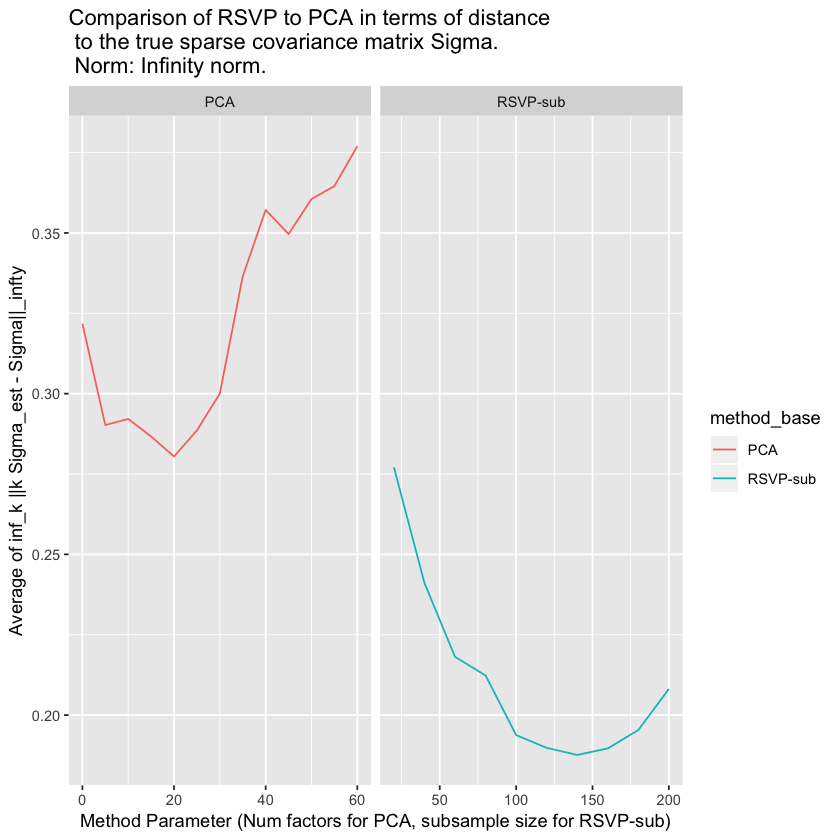

In [156]:
library(ggplot2)
ggplot(d, aes(x=(method_param), y=`smallest max norm`)) + 
stat_summary(fun.y=mean, geom="line", aes(colour=method_base)) + facet_wrap(~method_base, scales="free_x") +
ylab("Average of inf_k ||k Sigma_est - Sigma||_infty") + xlab("Method Parameter (Num factors for PCA, subsample size for RSVP-sub)") +
ggtitle('Comparison of RSVP to PCA in terms of distance\n to the true sparse covariance matrix Sigma.\n Norm: Infinity norm.')


In this setting, RSVP-sub does not seem very sensitive to its tuning parameter: choosing a small value of $m$ is computationally faster and yields good results. 

On the other hand, choosing the number of factors to remove with PCA is critical to its performance. 

# 2) *RSVP-graph*: Estimating a network between random variables based on the covariance matrix

Here, we simply use the estimate of the covariance matrix $\Sigma_{RSVP-sub}$ and rank its non-diagonal entries by magnitude. By keeping the k largest entries, we obtain the adjacency matrix of an undirected graph with $k$ edges. 
This provides an estimator for a network over the variables which is devoid of confounding. 

## R Code:
The following piece of code ranks the entries of a covariance matrix according to their magnitude and returns 
the adjacency matrix of a graph with $k$ edges. 

In [230]:
get_adjacency_matrix_from_covariance <- function(estimate, n.edges) {
    estimate <- estimate - diag(diag(estimate))
    threshold <- sort(abs(estimate), decreasing=TRUE)[2 * n.edges] # Because the matrix is symmetric 2*n.edges
    
    1.0 * (abs(estimate) >= threshold)
}

precision_and_recall <- function(estimate, ground.truth) {
    list(precision=sum(estimate * ground.truth)/sum(estimate), 
         recall=sum(estimate * ground.truth) / sum(ground.truth))
}

process_prec_rec <- function(precisions, recalls) {
    # Keep the convex hull of the function
    for (r in unique(recalls)) {
        idx <- recalls == r
        precisions[idx] <- max(precisions[idx])
    }
    
    # The curve is already ordered by recall
    for (i in 1:(length(recalls) - 1)) {
        right.p <- precisions[(i+1):length(precisions)]
        precisions[i] <- max(right.p)
    }
    
    
    list(precisions=precisions, recalls=recalls)
}

## Example on synthetic data

We generate some random data as before and use the `precision` and `recall` metrics to see whether the largest entries of $\Sigma_{RSVP-sub}$ are also the largest entries of the true covariance matrix $\Sigma$. We compare $\Sigma_{RSVP-sub}$ with $m = 100$ to the sample covariance matrix $\Sigma_{sample}$ as well as $\Sigma_{PCA}$ for $k = 20$.

In [207]:
# Generate some random data
p <- 1000
n <- 200
q <- 50
data <- get_synthetic_data(p=p, n=n, q=q, seed = 1)
X <- data$X
Sigma <- data$Sigma
    
m <- 100
Sigma_RSVP_sub <- RSVP_sub(X, m=m)
Sigma_sample <- cov(X) # This is PCA with 0 factors regressed out.
k <- 5 # Remove the top k principal components.
pca5 <- cov(get_PCA_estimation(X, k))
k <- 10 # Remove the top k principal components.
pca10 <- cov(get_PCA_estimation(X, k))
k <- 20 # Remove the top k principal components.
pca20 <- cov(get_PCA_estimation(X, k))

max.n.edges <- 200 # Compute the 200 first graphs of each path
gt <- get_adjacency_matrix_from_covariance(Sigma, max.n.edges)
prec_recs <- matrix(NA, ncol=3, nrow=0)
colnames(prec_recs) <- c("Method", "Precision", "Recall")
for (k in 1:max.n.edges) {
    # This is computationally suboptimal since we sort the entries each time
    # but it's simpler
    method <- 'RSVP-sub (m=100)'
    est <- get_adjacency_matrix_from_covariance(Sigma_RSVP_sub, k)
    pr <- precision_and_recall(est, gt)
    prec_recs <- rbind(prec_recs, cbind(method, pr$precision, pr$recall))
    method <- 'Sample Covariance Matrix'
    est <- get_adjacency_matrix_from_covariance(Sigma_sample, k)
    pr <- precision_and_recall(est, gt)
    prec_recs <- rbind(prec_recs, cbind(method, pr$precision, pr$recall))
    
    method <- 'PCA (k=5)'
    est <- get_adjacency_matrix_from_covariance(pca5, k)
    pr <- precision_and_recall(est, gt)
    prec_recs <- rbind(prec_recs, cbind(method, pr$precision, pr$recall))

    method <- 'PCA (k=10)'
    est <- get_adjacency_matrix_from_covariance(pca10, k)
    pr <- precision_and_recall(est, gt)
    prec_recs <- rbind(prec_recs, cbind(method, pr$precision, pr$recall))
    
    method <- 'PCA (k=20)'
    est <- get_adjacency_matrix_from_covariance(pca20, k)
    pr <- precision_and_recall(est, gt)
    prec_recs <- rbind(prec_recs, cbind(method, pr$precision, pr$recall))
}

In [231]:
d <- as.data.frame(prec_recs)[2:nrow(prec_recs),]
d$Precision <- as.numeric(as.character(d$Precision))
d$Recall <- as.numeric(as.character(d$Recall))
for (method in unique(d$Method)) {
    subD <- d[d$Method == method, ]
    prs <- process_prec_rec(subD$Precision, subD$Recall)
    d$Precision[d$Method == method] <- prs$precisions
    d$Recall[d$Method == method] <- prs$recalls
}

As before, we set $n = 200, p = 1000, q=50$ (200 samples, 1000 variables and 50 latent factors).

We set our "true graph" to be the graph defined by the 200 largest entries of the true covariance matrix $\Sigma$ and we compare methods using the precision and recall metrics.

Here are the results:

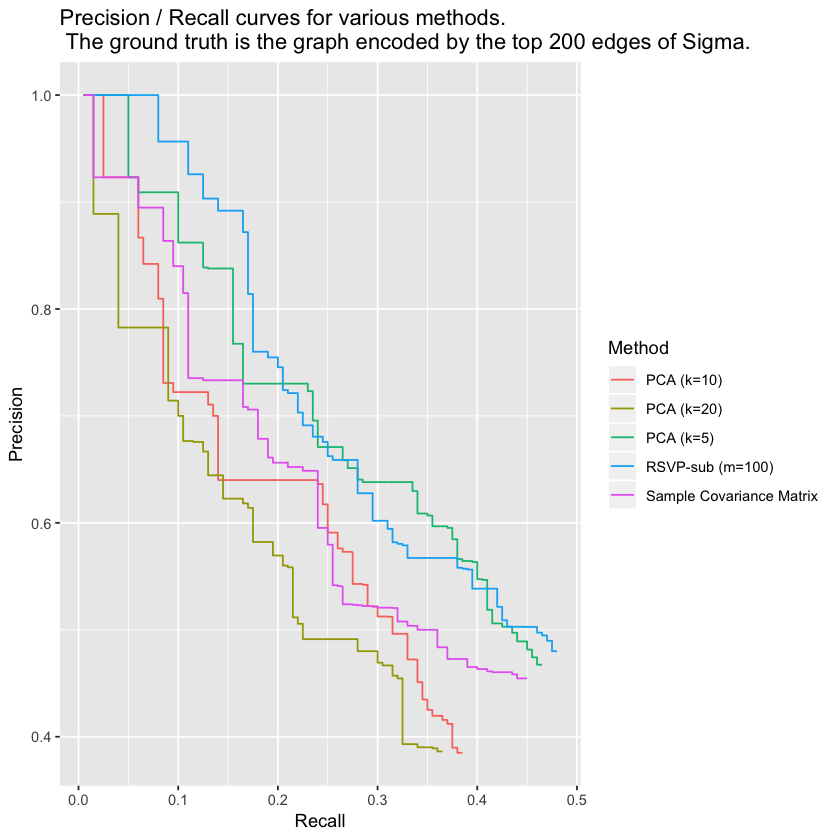

In [237]:
ggplot(d, aes(x=Recall, y=Precision)) + geom_line(aes(colour=Method)) + 
ggtitle("Precision / Recall curves for various methods.\n The ground truth is the graph encoded by the top 200 edges of Sigma.")

What we see above is that, once more, the PCA approach is very sensitive to the value of the number of PCs removed. If too many PCs are removed (k = 10, 20) the performance degrades quickly poor. Finding the right number of PCs is critical.

# 3) *RSVP-graphical-model*: Estimating a graphical model between variables by estimating the *inverse* covariance matrix.

We use the estimate of the covariance matrix $\Sigma_{RSVP-sub}$ in combination with another method (the lasso) to get an estimate of the support of $\Sigma^{-1}$. This is what is commonly done in the literature when it comes to estimate a graph over $p$ variables. To understand what is the connection between conditional independence and inverse covariance matrix as well as the motivation behind estimating a sparse matrix, see e.g. http://statweb.stanford.edu/~tibs/ftp/graph.pdf, https://projecteuclid.org/euclid.aos/1152540754 .

Thanks to the `glasso` package, we can easily estimate the support of the inverse covariance matrix given an estimate of $\Sigma$. In what follows, we compare $\Sigma_{RSVP-sub} (m = 100), \Sigma_{sample}$ and $\Sigma_{PCA}$ (num. of princ. comp. = 5).

In [337]:
# Generate some random data
p <- 1000
n <- 200
q <- 50
data <- get_synthetic_data(p=p, n=n, q=q, seed = 1)
X <- data$X
Sigma <- data$Sigma
Sigma_inv <- data$Sigma_inverse
k <- 5 # Remove the top k principal components.
pca5 <- cov(get_PCA_estimation(X, k))

m <- 100
Sigma_RSVP_sub <- RSVP_sub(X, m=m)
Sigma_sample <- cov(X)
St <- Sigma_inv != 0
St <- St - diag(diag(St))

In [343]:
library("glasso")

prec_recs <- matrix(NA, ncol=3, nrow=0)
colnames(prec_recs) <- c("Method", "Precision", "Recall")

# Compute the precision/recall path
method <- 'RSVP-sub (m=100)'
lmax <- max(abs(Sigma_RSVP_sub - diag(diag(Sigma_RSVP_sub)))) * 0.9
lmin <- lmax / 10
rhos <- lmax * (lmax / lmin)**(-(0:20)/20) # Geometric progression for the tuning parameters

wi.init <- NULL
w.init <- NULL
for(rho in rhos) {
    glasso.result <- glasso(Sigma_RSVP_sub, rho = rho, approx=TRUE, 
                            penalize.diagonal = FALSE, w.init=w.init, wi.init=wi.init)
    wi.init <- glasso.result$wi
    w.init <- glasso.result$w
    S <- glasso.result$wi
    S <- S - diag(diag(S))
    S <- S!=0
    pr <- precision_and_recall(S, St)
    prec_recs <- rbind(prec_recs, c(method, pr$precision, pr$recall))
}

# Compute the precision/recall path
method <- 'Sample covariance matrix'
lmax <- max(abs(Sigma_sample - diag(diag(Sigma_sample)))) * 0.9
lmin <- lmax / 10
rhos <- lmax * (lmax / lmin)**(-(0:20)/20) # Geometric progression for the tuning parameters

wi.init <- NULL
w.init <- NULL
for(rho in rhos) {
    glasso.result <- glasso(Sigma_sample, rho = rho, approx=TRUE, 
                            penalize.diagonal = FALSE, w.init=w.init, wi.init=wi.init)
    wi.init <- glasso.result$wi
    w.init <- glasso.result$w
    S <- glasso.result$wi
    S <- S - diag(diag(S))
    S <- S!=0
    pr <- precision_and_recall(S, St)
    prec_recs <- rbind(prec_recs, c(method, pr$precision, pr$recall))
}

method <- 'PCA (k = 5)'
lmax <- max(abs(pca5 - diag(diag(pca5)))) * 0.9
lmin <- lmax / 10
rhos <- lmax * (lmax / lmin)**(-(0:20)/20) # Geometric progression for the tuning parameters

wi.init <- NULL
w.init <- NULL
for(rho in rhos) {
    glasso.result <- glasso(pca5, rho = rho, approx=TRUE, 
                            penalize.diagonal = FALSE, w.init=w.init, wi.init=wi.init)
    wi.init <- glasso.result$wi
    w.init <- glasso.result$w
    S <- glasso.result$wi
    S <- S - diag(diag(S))
    S <- S!=0
    pr <- precision_and_recall(S, St)
    prec_recs <- rbind(prec_recs, c(method, pr$precision, pr$recall))
}

In [346]:
d <- as.data.frame(prec_recs)[2:nrow(prec_recs),]
d$Precision <- as.numeric(as.character(d$Precision))
d$Recall <- as.numeric(as.character(d$Recall))
for (method in unique(d$Method)) {
    subD <- d[d$Method == method, ]
    prs <- process_prec_rec(subD$Precision, subD$Recall)
    d$Precision[d$Method == method] <- prs$precisions
    d$Recall[d$Method == method] <- prs$recalls
}

Below, we show the precision / recall curves of the various methods for the estimation of the support of the inverse covariance matrix.

We estimate a covariance matrix with each of the methods and then estimate its inverse using neighbourhood selection with the lasso. We obtain graphs of different sparsities by varying the tuning parameter of the Lasso. 

Warning message:
“Removed 24 rows containing missing values (geom_path).”

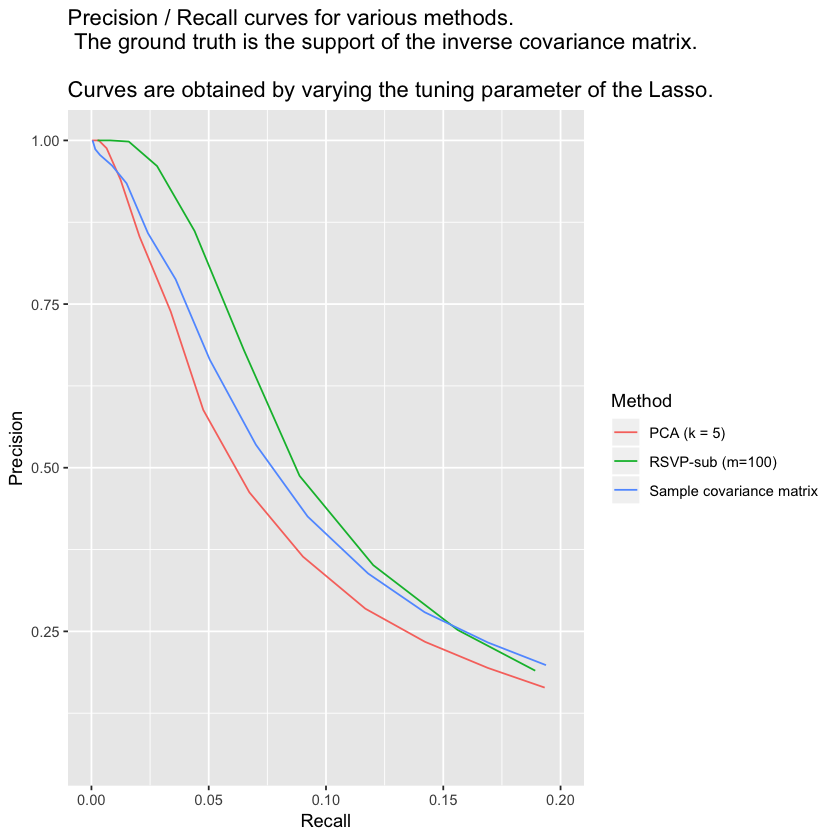

In [347]:
ggplot(d, aes(x=Recall, y=Precision)) + geom_line(aes(colour=Method)) + xlim(c(0,0.2)) +
ggtitle("Precision / Recall curves for various methods.\n The ground truth is the support of the inverse covariance matrix. \n 
Curves are obtained by varying the tuning parameter of the Lasso.")